<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

Network has perfoerct information(relative position),  with position and etc as inputs, try to see its generalization performance 

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import navigation2
from navigation2 import *

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/cruiser/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Qnetwork

To select actions we take maximum of Q value, corresponding to certain move.

For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  POMDP RNN Game

In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

In [2]:
pregame = PretrainGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)])
pregame.reset(set_agent=(2,2))
# rls_q = RLS(1)
# rls_sl = RLS(1)
# for i in range(1):
#     pregame.fulltrain(trials = 4)
    

In [3]:
game = ValueMaxGame(pregame.net, grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward =  [(0.5, 0.25), (0.5, 0.75)])
game.reset()
# game.experiment(rls_q, rls_sl, 20, epsilon = 0.5, lr = 1e-3, train_hidden = False, train_q = False) 

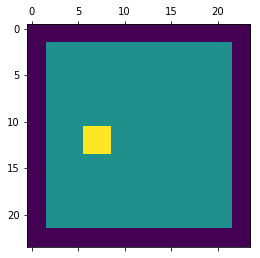

In [4]:
plt.matshow(game.grid.grid)
# plt.savefig('g16h3-map')

## Model Tranining 
Pretranining is done with fixed size 15,  training is between 10 to 15, test on 19 

Training from zero seems to be better because it will allow the agent to explore from new

In [5]:
# A complete experiment including pretraining , decoding training, and q learning  
class PretrainTest():
    def __init__(self, weight_write, holes = 0, inputs_type = (1, 0), eta = 0):
        self.pregame = PretrainGame(grid_size = (15, 15), holes = holes, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = inputs_type[0])
        self.game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], \
                                 input_type = inputs_type[1], eta = eta)
        self.weight = weight_write
  # load the necessary weights into network             
    def loadweight(self, weight_load):
#       need to take the state dict as a new dict for updating , here is only tensor of trained net
        net_dict = torch.load(weight_load)
        # ordered list to laod
        list_modules = [('h2h', net_dict['h2h']), ('a2h', net_dict['a2h']), ('i2h', net_dict['i2h']), ('r2h', net_dict['r2h']), ('bh', net_dict['bh'])]
        select_dict = OrderedDict(list_modules)
        # get the game net tensor as target
        net = self.game.net.state_dict()
        # update the network tensor
        net.update(select_dict)
        # relaod the new torsor
        self.game.net.load_state_dict(net)
        # save to place for update 
        torch.save(self.game.net.state_dict(), self.weight) 
    
        
    def pretrain(self, trial, weight = None, lr = 1e-5, pretrain = True):  
        # start a pretrained game  
        self.pregame.net.cuda()
        if pretrain == True:
            lr = float(lr)
            if weight != None:
                self.pregame.net.load_state_dict(torch.load(weight))
            self.pregame.fulltrain(lr_rate = lr, trials = int(1e3), batchsize = 4)
        print ('pretrain end', torch.norm(self.pregame.net.h2h))
        if pretrain == True:
            torch.save(self.pregame.net.state_dict(), self.weight[:-1]+'{}'.format(trial))
        else:
            torch.save(self.pregame.net.state_dict(), self.weight+'{}'.format(trial))
        if pretrain == True and trial <= 10:
            self.weight = self.weight[:-1]+'{}'.format(trial)
        elif pretrain == True and trial > 10:
            self.weight = self.weight[:-2]+'{}'.format(trial)
        elif pretrain == False:
            self.weight = self.weight +'{}'.format(trial)
            
    def decode(self, weight = None, size_range = np.arange(10, 21, 1), size_test = [10, 20], epsilon = 0):
        if weight != None:
            self.game.net.load_state_dict(torch.load(weight))
        else:
            self.pregame.net.load_state_dict(torch.load(self.weight))
            self.game.net= self.pregame.net.cpu()
        rls_q = RLS(1e2)
        rls_sl = RLS(1e2)
        self.game.net.cpu()
        self.game.experiment(rls_q, rls_sl, iterations = 160, epsilon = epsilon, train_hidden = False, train_q = False, size_range = size_range, test = True, decode = True) 
        # tested on size 15
        def precision(size = 15):
            prec0 = np.mean(decodetest(self.game, reward_control= 0, epsilon = epsilon)[0] + decodetest(self.game, reward_control = 1,  epsilon = 0, size = size)[0])
#             prec1 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 0.5)[0] + decodetest(self.game, reward_control =  1,  epsilon = 0.5)[0])
#             prec1 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 1)[0] + decodetest(self.game, reward_control =  1,  epsilon = 1, size = size)[0])
            return prec0
        print ('decode train finish')
        if len(size_test) == 2:
            Prec_s = precision(size = size_test[0])
            Prec_l = precision(size = size_test[1])
            print ('decode end', Prec_s, Prec_l)
            return Prec_s, Prec_l
        elif len(size_test) == 1:
            Prec_s = precision(size = size_test[0])
            print ('decode end', Prec_s)
            return Prec_s
        # q learning session 
        # q learning session 
    
        
    def qlearn(self, weight_read, weight_write, iterations = 5, save = True, size_train = np.arange(10, 51, 10), size_test = [10, 30], train_only = False, test_only = False, noise = 0.3):
        self.game.net.load_state_dict(torch.load(weight_read))
        e_rate = [noise for r in range(iterations)] 
        rls_q = RLS(1e2)
        rls_sl = RLS(1e2)
        Rewards = []
        # q leanring phase
        for n,e in enumerate(e_rate):
            prob = np.ones(len(size_train)) 
            prob = prob/np.sum(prob)
            if test_only == False:
                self.game.experiment(rls_q, rls_sl, iterations = 50, epochs= 10, epsilon = e, size_range = size_train)    
                if save == True:
                    torch.save(self.game.net.state_dict(), weight_write + '_{}'.format(n))
            def testing(game):
                Rewards00 = Test(game, reward_control = 0, size = size_test[0], test = 1)
                Rewards01 = Test(game, reward_control = 1, size = size_test[0], test = 1)
                rewards_s = (np.sum(Rewards00) + np.sum(Rewards01))/2
                Rewards10 = Test(game, reward_control = 0, size = size_test[1], test = 2)
                Rewards11 = Test(game, reward_control = 1, size = size_test[1], test = 2)
                rewards_l = (np.sum(Rewards10) + np.sum(Rewards11))/2
                return rewards_s, rewards_l
            # load weight if test only is true 
            if test_only == True:
                self.game.net.load_state_dict(torch.load(weight_write))
            if train_only == False:
                rewards_s, rewards_l = testing(self.game)
            print (n, 'rewards_s',  rewards_s, 'rewards_l', rewards_l)
            Rewards.append((rewards_s, rewards_l))
        return Rewards
    
    def TestAllSizes(self, weight_read, size_range = np.arange(5, 50, 5)):
        self.pregame.net.load_state_dict(torch.load(weight_read))
        self.game.net.cpu()
        self.Performance = []
        for size in size_range:
            Rewards0 = Test(self.game, reward_control = 0, size = size)
            Rewards1 = Test(self.game, reward_control = 1, size = size)
            self.Performance.append((Rewards0 + Rewards1)/2)

In [3]:
trial = 0
Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint0', inputs_type=(1, 1))
Pretest.loadweight(Pretest.weight)
weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)
Prec = Pretest.decode(weight = weight, size_range = [15], size_test = [15])

clear session data 159 2437271552
decode train finish
decode end 0.20818470155720198


In [4]:
trial = 0
Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint0', inputs_type=(1, 0))
Pretest.loadweight(Pretest.weight)
weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)
Prec = Pretest.decode(weight = weight, size_range = [15], size_test = [15])

clear session data 159 2437632000
decode train finish
decode end 0.12937955252363179


In [9]:
for iters, noise in enumerate(5 * [0.0]):
    for trial in [0]: 
        Pretest =  PretrainTest(holes = 0, inputs_type = (1, 0), weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial), eta = 0)
        Pretest.loadweight(Pretest.weight)
        weight_read = Pretest.weight
        weight_write = 'weights2/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 10, noise = noise, size_train = np.arange(10, 51, 10), size_test=[10, 50])


clear session data 49 11872083968
0 rewards_s 0.390830963326 rewards_l -0.423678869409
clear session data 49 11872231424
1 rewards_s 0.436225948114 rewards_l -0.399544269102
clear session data 49 11872256000
2 rewards_s 0.62916094797 rewards_l -0.540625037733
clear session data 49 11872256000
3 rewards_s 0.728031415995 rewards_l -0.566300039004
clear session data 49 11872256000
4 rewards_s 0.580971783205 rewards_l -0.211610153698
clear session data 49 11872256000
5 rewards_s 0.53183148714 rewards_l -0.363908274474
clear session data 49 11872301056
6 rewards_s 0.511274177534 rewards_l -0.287300342776
clear session data 49 11872301056
7 rewards_s 0.62531386424 rewards_l -0.280478106139
clear session data 49 11872301056
8 rewards_s 0.627706432413 rewards_l -0.583890532026
clear session data 49 11872301056
9 rewards_s 0.600464582932 rewards_l -0.57040429385
clear session data 49 11872301056
0 rewards_s 0.594432359715 rewards_l -0.631091545504
clear session data 49 11872301056
1 rewards_s 0

## Model Test